<a href="https://colab.research.google.com/github/ImagingDataCommons/ai_medima_misc/blob/main/nnunet/notebooks/models_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IDC nnUNet Use-case: Results Visualization**

... and Brief Description here.

## **Environment Setup**

In [2]:
import os
import sys
import pprint

# useful information
curr_dir = !pwd
curr_droid = !hostname
curr_pilot = !whoami

print("\nCurrent directory :", curr_dir[-1])
print("Hostname          :", curr_droid[-1])
print("Username          :", curr_pilot[-1])

print("Python version    :", sys.version.split('\n')[0])


Current directory : /content
Hostname          : a5165a1a3d3f
Username          : root
Python version    : 3.7.13 (default, Mar 16 2022, 17:37:17) 


In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
from google.cloud import storage

bucket_name = 'idc-medima-paper'
project_name = "idc-sandbox-000"

# location where to store the data (and check if a patient was processed already)
# if a patient was processed already, copy over the segmentation and run only
# the post-processing (split the masks, etc.)
bucket_base_uri = "gs://%s/"%(bucket_name)

In [5]:
# create the directory tree
!mkdir -p data 

!mkdir -p data/raw 
!mkdir -p data/raw/tmp data/raw/nsclc-radiomics
!mkdir -p data/raw/nsclc-radiomics/dicom

!mkdir -p data/processed
!mkdir -p data/processed/nsclc-radiomics
!mkdir -p data/processed/nsclc-radiomics/nrrd
!mkdir -p data/processed/nsclc-radiomics/nii
!mkdir -p data/processed/nsclc-radiomics/dicomseg

---

# **Quantitative Evaluation**

Evaluate quantitatively using [...]


In [66]:
import random
import numpy as np
import pandas as pd

from scipy.stats import gaussian_kde

# ----------------------------------------

# everything that has to do with plotting goes here below
import seaborn as sns
sns.set(style = "whitegrid")

import matplotlib
matplotlib.use('agg')

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

from mpl_toolkits.mplot3d import Axes3D

from matplotlib.colors import ListedColormap

%matplotlib inline
#%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'svg'

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## ----------------------------------------

# create new colormap appending the alpha channel to the selected one
# (so that we don't get a "color overlay" when plotting the segmask superimposed to the CT)
cmap = plt.cm.Reds
my_reds = cmap(np.arange(cmap.N))
my_reds[:,-1] = np.linspace(0, 1, cmap.N)
my_reds = ListedColormap(my_reds)

cmap = plt.cm.Greens
my_greens = cmap(np.arange(cmap.N))
my_greens[:,-1] = np.linspace(0, 1, cmap.N)
my_greens = ListedColormap(my_greens)

cmap = plt.cm.Blues
my_blues = cmap(np.arange(cmap.N))
my_blues[:,-1] = np.linspace(0, 1, cmap.N)
my_blues = ListedColormap(my_blues)

cmap = plt.cm.spring
my_spring = cmap(np.arange(cmap.N))
my_spring[:,-1] = np.linspace(0, 1, cmap.N)
my_spring = ListedColormap(my_spring)

## ----------------------------------------

import plotly.express as px

Set some paths and select the model we want to visualise the results of:

In [7]:
data_base_path = "/content/data"
raw_base_path = "/content/data/raw/tmp"
sorted_base_path = "/content/data/raw/nsclc-radiomics/dicom"

processed_base_path = "/content/data/processed/nsclc-radiomics/"
processed_nrrd_path = os.path.join(processed_base_path, "nrrd")
processed_dicomseg_path = os.path.join(processed_base_path, "dicomseg")

bucket_output_base_uri = os.path.join(bucket_base_uri, "nnunet/nnunet_output")

# -----------------
# nnU-Net pipeline parameters

# model: choose from "2d", "3d_lowres", "3d_fullres", "3d_cascade_fullres"
# test-time augmentation: choose from "-tta" and "-no_tta"
compare_models_list = ["2d-no_tta", "3d_lowres-no_tta", "2d-tta", "3d_lowres-tta"]

In [8]:
def generate_models_dict(compare_models_list, bucket_output_base_uri):

  """
  Function description here.

  Arguments:
    compare_models_list - required: 

  Returns:
    compare_models_dict   

  """

  compare_models_dict = dict()

  for nnunet_model in compare_models_list:
    
    compare_models_dict[nnunet_model] = dict()

    model_family = nnunet_model.split("-")[0]

    tta_str = "TTA" if "-tta" in nnunet_model else "no-TTA"

    experiment_folder_name = nnunet_model
    bucket_experiment_folder_uri = os.path.join(bucket_output_base_uri, experiment_folder_name)

    bucket_log_folder_uri = os.path.join(bucket_experiment_folder_uri, 'log')
    bucket_eval_folder_uri = os.path.join(bucket_experiment_folder_uri, 'eval')
    bucket_dicomseg_folder_uri = os.path.join(bucket_experiment_folder_uri, 'dicomseg')

    compare_models_dict[nnunet_model]["model_family"] = model_family
    compare_models_dict[nnunet_model]["tta_str"] = tta_str
    compare_models_dict[nnunet_model]["experiment_folder_name"] = experiment_folder_name
    compare_models_dict[nnunet_model]["bucket_log_folder_uri"] = bucket_log_folder_uri
    compare_models_dict[nnunet_model]["bucket_eval_folder_uri"] = bucket_eval_folder_uri
    compare_models_dict[nnunet_model]["bucket_dicomseg_folder_uri"] = bucket_dicomseg_folder_uri

  return compare_models_dict

In [9]:
# populate a list of dictionaries with the models to compare and all
# the associated information needed to download the data from the buckets
compare_models_dict = generate_models_dict(compare_models_list = compare_models_list,
                                           bucket_output_base_uri = bucket_output_base_uri)

## **Print Function Definition**

Define some useful functions:

In [10]:
def format_dict(df_dict, quantity_column_name):
  
  """
  Function description here.

  Arguments:
    df_dict - required: 

  Outputs:


  """

  for nnunet_model in df_dict:
  
    df = df_dict[nnunet_model][["PatientID", quantity_column_name]]

    try:
      data = data.merge(df, on = "PatientID", how = "left")
      data = data.rename(columns = {quantity_column_name : nnunet_model})
    except:
      data = df
      data = data.rename(columns = {quantity_column_name : nnunet_model})

  return data

In [11]:
def comparison_boxplot(df_dict, quantity_column_name, quantity_name,
                       palette, fig_suptitle, ylim, add_beeswarm = False):

  """
  Function description here.

  Arguments:
    df_dict - required: 

  Outputs:

  """

  fig, ax_box  = plt.subplots(1, 1, figsize = (2.5*len(inference_time_df_dict), 6))

  data = format_dict(df_dict, quantity_column_name)

  sns.boxplot(data = data, ax = ax_box, width = 0.15, linewidth = .75, palette = palette)
  
  if add_beeswarm == True:
    sns.swarmplot(data = data, ax = ax_box, palette = palette, edgecolor = "black",
                  alpha = .5, size = 2.5)

  ax_box.set_ylim(ylim)
  ax_box.set_ylabel(quantity_name)

  _ = fig.suptitle(fig_suptitle)

---

In [59]:
def interactive_comparison_boxplot(df, quantity_name, palette, fig_title, ylim):

  """
  Function description here.

  Arguments:
    df_dict - required: 

  Outputs:

  """

  fig = px.box(df,
               color = "model",
               color_discrete_sequence = palette,
               points = "all", 
               hover_name = df.index,
               width = 1000, height = 700,
               title = fig_title,
               labels = {"model" : "nnU-Net Model",
                         "value" : quantity_name})

  fig.update_traces(width = 0.2, 
                    whiskerwidth = 0.4,
                    pointpos = -2)

  fig.update_layout(font = {"family" : "Times New Roman", "size" : 18},
                    paper_bgcolor = "rgba(0,0,0,0)",
                    plot_bgcolor = "rgba(0,0,0,0)",
                    showlegend = False)

  fig.update_xaxes(showgrid = True,
                   gridwidth = 1, gridcolor = "lightgray",
                   mirror = True, ticks = "outside",
                   linecolor = "lightgray", showline = True)

  fig.update_yaxes(range = ylim, showgrid = True,
                   gridwidth = 1, gridcolor = 'lightgray',
                   mirror = True, ticks = "outside",
                   linecolor = "lightgray", showline = True)
  
  fig.show()

In [67]:
palette = random.sample(population = px.colors.qualitative.T10,
                        k = len(compare_models_list))

---

## **Processing Time**

In [68]:
# cross-load the evaluation results from the bucket, for each of the specified models

# inference time
csv_fn = "inference_time.csv"
csv_path_list = list()

for nnunet_model in compare_models_dict:

  csv_path = os.path.join(data_base_path, nnunet_model + "_" + csv_fn)
  csv_path_list.append(csv_path)

  bucket_log_folder_uri = compare_models_dict[nnunet_model]["bucket_log_folder_uri"]
  gs_uri_csv_file = os.path.join(bucket_log_folder_uri, csv_fn)

  !gsutil -m cp $gs_uri_csv_file $csv_path

Copying gs://idc-medima-paper/nnunet/nnunet_output/2d-no_tta/log/inference_time.csv...
/ [1/1 files][ 11.0 KiB/ 11.0 KiB] 100% Done                                    
Operation completed over 1 objects/11.0 KiB.                                     
Copying gs://idc-medima-paper/nnunet/nnunet_output/3d_lowres-no_tta/log/inference_time.csv...
/ [1/1 files][ 11.0 KiB/ 11.0 KiB] 100% Done                                    
Operation completed over 1 objects/11.0 KiB.                                     
Copying gs://idc-medima-paper/nnunet/nnunet_output/2d-tta/log/inference_time.csv...
/ [1/1 files][ 11.3 KiB/ 11.3 KiB] 100% Done                                    
Operation completed over 1 objects/11.3 KiB.                                     
Copying gs://idc-medima-paper/nnunet/nnunet_output/3d_lowres-tta/log/inference_time.csv...
/ [1/1 files][ 11.2 KiB/ 11.2 KiB] 100% Done                                    
Operation completed over 1 objects/11.2 KiB.                              

### **Static Boxplot**

In [69]:
inference_time_df_dict = dict()

for nnunet_model, csv_path in zip(compare_models_list, csv_path_list):

  inference_time_df = pd.read_csv(csv_path, index_col = [0])

  # add minutes
  inference_time_df["inference_time_minutes"] = inference_time_df["inference_time"]/60

  inference_time_df_dict[nnunet_model] = inference_time_df

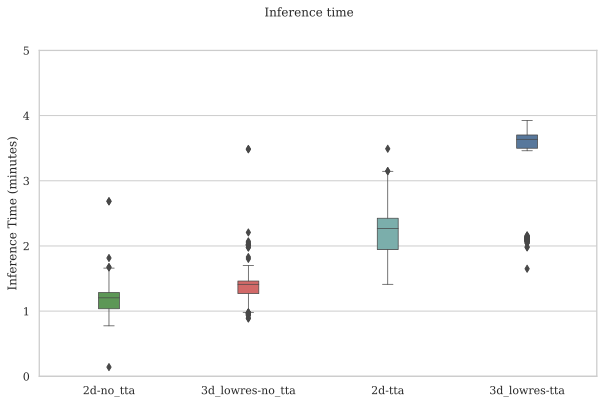

In [70]:
comparison_boxplot(df_dict = inference_time_df_dict,
                   quantity_column_name = "inference_time_minutes",
                   quantity_name = "Inference Time (minutes)",
                   fig_suptitle = "Inference time",
                   palette = palette,
                   add_beeswarm = False,
                   ylim = [0, 5])

### **Interactive Boxplot**

In [71]:
# prep data for plotly express plot - long dataframe
inference_time_df_all = pd.DataFrame()

for nnunet_model, csv_path in zip(compare_models_list, csv_path_list):

  inference_time_df = pd.read_csv(csv_path, index_col = [0])

  # add minutes
  inference_time_df["inference_time_minutes"] = inference_time_df["inference_time"]/60
  inference_time_df["model"] = nnunet_model

  inference_time_df_all = pd.concat([inference_time_df_all, inference_time_df])

# long to wide dataframe
inference_time_df_all = inference_time_df_all.pivot_table(index = "PatientID",
                                                          columns = "model",
                                                          values = "inference_time_minutes")

In [72]:
interactive_comparison_boxplot(df = inference_time_df_all,
                               quantity_name = "Inference Time (minutes)",
                               palette = palette,
                               fig_title = "Inference time for different nnU-Net models",
                               ylim = [0, 5])

---

## **Dice Similarity Coefficient**

### **Heart**

In [73]:
# cross-load the evaluation results from the bucket, for each of the specified models

# inference time
csv_fn = "dc_heart.csv"
csv_path_list = list()

for nnunet_model in compare_models_dict:

  csv_path = os.path.join(data_base_path, nnunet_model + "_" + csv_fn)
  csv_path_list.append(csv_path)

  bucket_eval_folder_uri = compare_models_dict[nnunet_model]["bucket_eval_folder_uri"]
  gs_uri_csv_file = os.path.join(bucket_eval_folder_uri, csv_fn)

  !gsutil -m cp $gs_uri_csv_file $csv_path

Copying gs://idc-medima-paper/nnunet/nnunet_output/2d-no_tta/eval/dc_heart.csv...
/ [1/1 files][  8.9 KiB/  8.9 KiB] 100% Done                                    
Operation completed over 1 objects/8.9 KiB.                                      
Copying gs://idc-medima-paper/nnunet/nnunet_output/3d_lowres-no_tta/eval/dc_heart.csv...
/ [1/1 files][  8.9 KiB/  8.9 KiB] 100% Done                                    
Operation completed over 1 objects/8.9 KiB.                                      
Copying gs://idc-medima-paper/nnunet/nnunet_output/2d-tta/eval/dc_heart.csv...
/ [1/1 files][  8.9 KiB/  8.9 KiB] 100% Done                                    
Operation completed over 1 objects/8.9 KiB.                                      
Copying gs://idc-medima-paper/nnunet/nnunet_output/3d_lowres-tta/eval/dc_heart.csv...
/ [1/1 files][  8.9 KiB/  8.9 KiB] 100% Done                                    
Operation completed over 1 objects/8.9 KiB.                                      


#### **Static Boxplot**

In [74]:
dc_heart_df_dict = dict()

for nnunet_model, csv_path in zip(compare_models_list, csv_path_list):

  dc_heart_df = pd.read_csv(csv_path, index_col = [0])

  dc_heart_df_dict[nnunet_model] = dc_heart_df

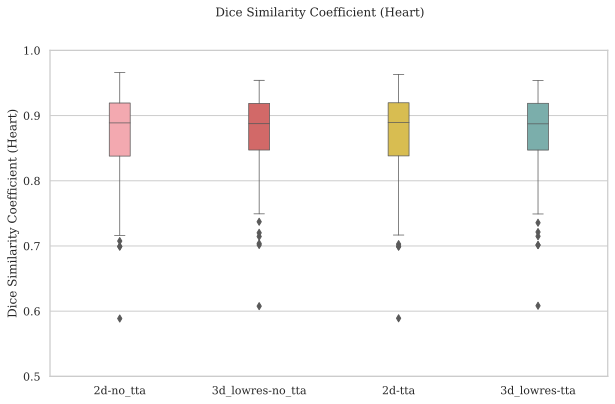

In [75]:
comparison_boxplot(df_dict = dc_heart_df_dict,
                   quantity_column_name = "dc",
                   quantity_name = "Dice Similarity Coefficient (Heart)",
                   fig_suptitle = "Dice Similarity Coefficient (Heart)",
                   palette = palette,
                   add_beeswarm = False,
                   ylim = [0.5, 1])

#### **Interactive Boxplot**

In [76]:
# prep data for plotly express plot - long dataframe
dc_heart_df_all = pd.DataFrame()

for nnunet_model, csv_path in zip(compare_models_list, csv_path_list):

  dc_heart_df = pd.read_csv(csv_path, index_col = [0])

  # add minutes
  dc_heart_df["model"] = nnunet_model

  dc_heart_df_all = pd.concat([dc_heart_df_all, dc_heart_df])

# long to wide dataframe
dc_heart_df_all = dc_heart_df_all.pivot_table(index = "PatientID",
                                              columns = "model",
                                              values = "dc")

In [78]:
interactive_comparison_boxplot(df = dc_heart_df_all,
                               quantity_name = "Dice Similarity Coefficient",
                               palette = palette,
                               fig_title = "Dice Similarity Coefficient (Heart) for different nnU-Net models",
                               ylim = [0, 1])

### **Esophagus**

In [81]:
# cross-load the evaluation results from the bucket, for each of the specified models

# inference time
csv_fn = "dc_esophagus.csv"
csv_path_list = list()

for nnunet_model in compare_models_dict:

  csv_path = os.path.join(data_base_path, nnunet_model + "_" + csv_fn)
  csv_path_list.append(csv_path)

  bucket_eval_folder_uri = compare_models_dict[nnunet_model]["bucket_eval_folder_uri"]
  gs_uri_csv_file = os.path.join(bucket_eval_folder_uri, csv_fn)

  !gsutil -m cp $gs_uri_csv_file $csv_path

Copying gs://idc-medima-paper/nnunet/nnunet_output/2d-no_tta/eval/dc_esophagus.csv...
/ [1/1 files][ 25.0 KiB/ 25.0 KiB] 100% Done                                    
Operation completed over 1 objects/25.0 KiB.                                     
Copying gs://idc-medima-paper/nnunet/nnunet_output/3d_lowres-no_tta/eval/dc_esophagus.csv...
/ [1/1 files][ 25.0 KiB/ 25.0 KiB] 100% Done                                    
Operation completed over 1 objects/25.0 KiB.                                     
Copying gs://idc-medima-paper/nnunet/nnunet_output/2d-tta/eval/dc_esophagus.csv...
/ [1/1 files][ 25.0 KiB/ 25.0 KiB] 100% Done                                    
Operation completed over 1 objects/25.0 KiB.                                     
Copying gs://idc-medima-paper/nnunet/nnunet_output/3d_lowres-tta/eval/dc_esophagus.csv...
/ [1/1 files][ 25.0 KiB/ 25.0 KiB] 100% Done                                    
Operation completed over 1 objects/25.0 KiB.                                  

#### **Static Boxplot**

In [82]:
dc_esophagus_df_dict = dict()

for nnunet_model, csv_path in zip(compare_models_list, csv_path_list):

  dc_esophagus_df = pd.read_csv(csv_path, index_col = [0])

  dc_esophagus_df_dict[nnunet_model] = dc_esophagus_df

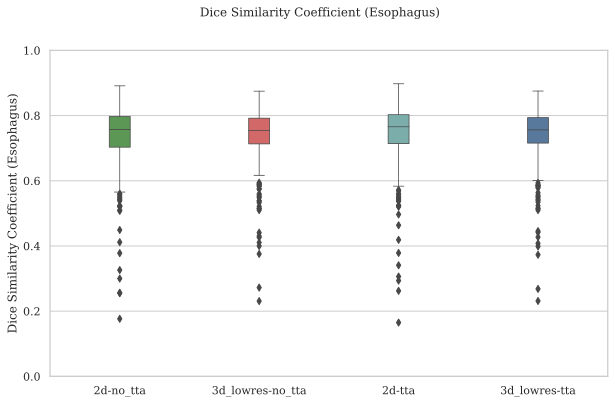

In [83]:
comparison_boxplot(df_dict = dc_esophagus_df_dict,
                   quantity_column_name = "dc",
                   quantity_name = "Dice Similarity Coefficient (Esophagus)",
                   fig_suptitle = "Dice Similarity Coefficient (Esophagus)",
                   palette = palette,
                   add_beeswarm = False,
                   ylim = [0, 1])

#### **Interactive Boxplot**

In [85]:
# prep data for plotly express plot - long dataframe
dc_esophagus_df_all = pd.DataFrame()

for nnunet_model, csv_path in zip(compare_models_list, csv_path_list):

  dc_esophagus_df = pd.read_csv(csv_path, index_col = [0])

  # add minutes
  dc_esophagus_df["model"] = nnunet_model

  dc_esophagus_df_all = pd.concat([dc_esophagus_df_all, dc_esophagus_df])

# long to wide dataframe
dc_esophagus_df_all = dc_esophagus_df_all.pivot_table(index = "PatientID",
                                                      columns = "model",
                                                      values = "dc")

In [86]:
interactive_comparison_boxplot(df = dc_esophagus_df_all,
                               quantity_name = "Dice Similarity Coefficient",
                               palette = palette,
                               fig_title = "Dice Similarity Coefficient (Esophagus) for different nnU-Net models",
                               ylim = [0, 1])

## **Scatterplot (model-model)**

### **Static Scatterplots**

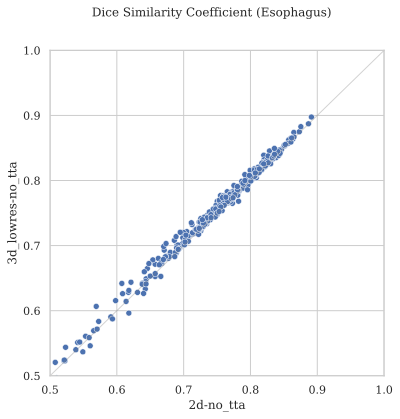

In [61]:
#scatterplot_models_list = ["2d-no_tta", "2d-tta"]
#scatterplot_models_list = ["2d-no_tta", "2d-tta"]
scatterplot_models_list = ["2d-no_tta", "3d_lowres-no_tta"]

df = format_dict(df_dict = dc_esophagus_df_dict,
                 quantity_column_name = "dc")

fig, ax_scatter  = plt.subplots(1, 1, figsize = (6, 6))

sns.lineplot(x = [0, 1], y = [0, 1], color = 'gray', linewidth = 1, alpha = 0.35)

sns.scatterplot(data = df, x = scatterplot_models_list[0], y = scatterplot_models_list[1],
                ax = ax_scatter, color = sns.color_palette("deep")[0])

ax_scatter.set_ylim([0.5, 1])
ax_scatter.set_xlim([0.5, 1])

_ = fig.suptitle("Dice Similarity Coefficient (Esophagus)")


### **Interactive Scatterplot**

In [213]:
fig = px.scatter(df,
                 x = scatterplot_models_list[0],
                 y = scatterplot_models_list[1],
                 hover_data = ["PatientID"],
                 trendline = "ols",
                 trendline_color_override = "gray",
                 color_discrete_sequence = [px.colors.qualitative.D3[0]],
                 width = 800, height = 800)

# update trend line
for  k, trace  in enumerate(fig.data):
  if trace.mode is not None and trace.mode == 'lines':
    fig.data[k].update({"line_width" : 1,
                        "line_dash" : "dot"})

fig.update_layout(font = {"family" : "Times New Roman", "size" : 18},
                  paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)")

fig.update_traces(marker = {"size" : 8,
                            "line" : {"width" : 1, "color" : 'DarkSlateGrey'}},
                  selector = {"mode" : "markers"})

fig.update_xaxes(range = [0.2, 1], showgrid = True,
                 gridwidth = 1, gridcolor = "lightgray",
                 mirror = True, ticks = "outside",
                 linecolor = "lightgray", showline = True)

fig.update_yaxes(range = [0.2, 1], showgrid = True,
                 gridwidth = 1, gridcolor = 'lightgray',
                 mirror = True, ticks = "outside",
                 linecolor = "lightgray", showline = True)

---

# **Qualitative Evaluation**

In [ ]:
!mkdir -p src

!git clone https://github.com/pieper/dicomsort src/dicomsort
!git clone https://github.com/AIM-Harvard/pyplastimatch src/pyplastimatch

Cloning into 'src/dicomsort'...
remote: Enumerating objects: 126, done.
remote: Total 126 (delta 0), reused 0 (delta 0), pack-reused 126
Receiving objects: 100% (126/126), 37.03 KiB | 6.17 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Cloning into 'src/pyplastimatch'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (333/333), done.
remote: Compressing objects: 100% (314/314), done.
remote: Total 333 (delta 31), reused 302 (delta 12), pack-reused 0
Receiving objects: 100% (333/333), 55.56 MiB | 27.12 MiB/s, done.
Resolving deltas: 100% (31/31), done.


Install Plastimatch [...] and check the process was successful.

In [ ]:
%%capture
!apt install plastimatch

In [ ]:
# check plastimatch was correctly installed
!plastimatch --version

plastimatch version 1.7.0


In [ ]:
import pandas as pd
from google.cloud import bigquery as bq

In [ ]:
# FIXME: for development purposes - we will switch to a proper query soon!

# name of the project
PROJECT_NAME = "idc-sandbox-000"

# name of the BQ dataset where the table is copied
DATASET_NAME = "dennis_cohorts"

# name of the BQ table copied from IDC to the user's own project
TABLE_NAME = "nsclc-nnunet-he"

# Table ID to use with the BQ command
TABLE_ID = "%s.%s.%s"%(PROJECT_NAME, DATASET_NAME, TABLE_NAME)

In [ ]:
# the query we are going to execute to gather data about the selected cohort
query_str = "SELECT * FROM `%s`"%(TABLE_ID)

# init the BQ client
client = bq.Client(project = "idc-sandbox-000")

# run the query
query_job = client.query(query_str)

# convert the results to a Pandas dataframe
cohort_df = query_job.to_dataframe()

## **Parsing Cohort Information from BigQuery Tables**

In [ ]:
# FIXME: for debug purposes, only process a handful of patients for now
pat_id_list = sorted(list(set(cohort_df["PatientID"].values)))

print("Total number of unique Patient IDs:", len(pat_id_list))

display(cohort_df.info())

display(cohort_df.head())

Total number of unique Patient IDs: 357
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44157 entries, 0 to 44156
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   PatientID           44157 non-null  object
 1   collection_id       44157 non-null  object
 2   source_DOI          44157 non-null  object
 3   StudyInstanceUID    44157 non-null  object
 4   SeriesInstanceUID   44157 non-null  object
 5   SOPInstanceUID      44157 non-null  object
 6   crdc_study_uuid     44157 non-null  object
 7   crdc_series_uuid    44157 non-null  object
 8   crdc_instance_uuid  44157 non-null  object
 9   gcs_url             44157 non-null  object
 10  idc_version         44157 non-null  object
dtypes: object(11)
memory usage: 3.7+ MB


None

,PatientID,collection_id,source_DOI,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,crdc_study_uuid,crdc_series_uuid,crdc_instance_uuid,gcs_url,idc_version
0,LUNG1-389,nsclc_radiomics,10.7937/K9/TCIA.2015.PF0M9REI,1.3.6.1.4.1.32722.99.99.3103908869703256044664...,1.3.6.1.4.1.32722.99.99.2352658665619663766339...,1.3.6.1.4.1.32722.99.99.2414242025218459804872...,0184ddf7-bf1c-4812-ae58-37f0f62eef51,b3324cee-7e85-4b2c-ae2d-4b89a8da50ca,034324d3-0089-4726-bfbb-cd754febde6c,gs://idc-dev-cr/034324d3-0089-4726-bfbb-cd754f...,7.0
1,LUNG1-389,nsclc_radiomics,10.7937/K9/TCIA.2015.PF0M9REI,1.3.6.1.4.1.32722.99.99.3103908869703256044664...,1.3.6.1.4.1.32722.99.99.2352658665619663766339...,1.3.6.1.4.1.32722.99.99.2648221267343378996555...,0184ddf7-bf1c-4812-ae58-37f0f62eef51,b3324cee-7e85-4b2c-ae2d-4b89a8da50ca,053d8545-4adf-44b9-9776-2f149b255796,gs://idc-dev-cr/053d8545-4adf-44b9-9776-2f149b...,7.0
2,LUNG1-389,nsclc_radiomics,10.7937/K9/TCIA.2015.PF0M9REI,1.3.6.1.4.1.32722.99.99.3103908869703256044664...,1.3.6.1.4.1.32722.99.99.2352658665619663766339...,1.3.6.1.4.1.32722.99.99.2483895798395217229931...,0184ddf7-bf1c-4812-ae58-37f0f62eef51,b3324cee-7e85-4b2c-ae2d-4b89a8da50ca,065427e7-c0de-41f1-9cdb-2cd28ee2009c,gs://idc-dev-cr/065427e7-c0de-41f1-9cdb-2cd28e...,7.0
3,LUNG1-389,nsclc_radiomics,10.7937/K9/TCIA.2015.PF0M9REI,1.3.6.1.4.1.32722.99.99.3103908869703256044664...,1.3.6.1.4.1.32722.99.99.2352658665619663766339...,1.3.6.1.4.1.32722.99.99.2829070204870971800854...,0184ddf7-bf1c-4812-ae58-37f0f62eef51,b3324cee-7e85-4b2c-ae2d-4b89a8da50ca,0799aa73-2587-4214-a22a-95d6bb323466,gs://idc-dev-cr/0799aa73-2587-4214-a22a-95d6bb...,7.0
4,LUNG1-389,nsclc_radiomics,10.7937/K9/TCIA.2015.PF0M9REI,1.3.6.1.4.1.32722.99.99.3103908869703256044664...,1.3.6.1.4.1.32722.99.99.2352658665619663766339...,1.3.6.1.4.1.32722.99.99.3684779892051361103024...,0184ddf7-bf1c-4812-ae58-37f0f62eef51,b3324cee-7e85-4b2c-ae2d-4b89a8da50ca,0caa0508-e7f0-4ab6-b514-1c035d1c34d9,gs://idc-dev-cr/0caa0508-e7f0-4ab6-b514-1c035d...,7.0


## **In-notebook Segmentation Visualization**

In [ ]:
data_base_path = "/content/data"
raw_base_path = "/content/data/raw/tmp"
sorted_base_path = "/content/data/raw/nsclc-radiomics/dicom"

processed_base_path = "/content/data/processed/nsclc-radiomics/"
processed_nrrd_path = os.path.join(processed_base_path, "nrrd")
processed_nifti_path = os.path.join(processed_base_path, "nii")
processed_dicomseg_path = os.path.join(processed_base_path, "dicomseg")

model_input_folder = "/content/data/model_input/"
model_output_folder = "/content/data/nnunet_output/"

bucket_output_base_uri = os.path.join(bucket_base_uri, "nnunet/nnunet_output")

# -----------------
# nnU-Net pipeline parameters

nnunet_model = "3d_lowres"
use_tta = False

# TO-DO - still need to be implemented properly!
#         save these under another folder in the bucket!
export_prob_maps = False

experiment_folder_name = nnunet_model + "-tta" if use_tta == True else nnunet_model + "-no_tta"
bucket_experiment_folder_uri = os.path.join(bucket_output_base_uri, experiment_folder_name)

bucket_log_folder_uri = os.path.join(bucket_experiment_folder_uri, 'log')
bucket_nifti_folder_uri = os.path.join(bucket_experiment_folder_uri, 'nii')
bucket_dicomseg_folder_uri = os.path.join(bucket_experiment_folder_uri, 'dicomseg')

# TO-DO: salve run information?
#
# 

---
